In [3]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(lubridate)
install.packages("zoo")
library(zoo)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Installing package into ‘/home/WUR/manza003/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message in install.packages("zoo"):
“installation of package ‘zoo’ had non-zero exit status”

Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [4]:
rawCH4 <- read.table("output.txt", sep = ",", stringsAsFactors = F, header = T)  
colnames(rawCH4)
head(rawCH4)
dim(rawCH4)

,cow,date,ch4,co2
,<int>,<chr>,<dbl>,<dbl>
1,59,2022/18/02 00:00:01,0.042,0.512
2,59,2022/18/02 00:00:02,0.042,0.520
3,59,2022/18/02 00:00:03,0.041,0.521
4,59,2022/18/02 00:00:04,0.041,0.526
5,59,2022/18/02 00:00:05,0.041,0.527
6,59,2022/18/02 00:00:06,0.041,0.529


[1] 140188      4

In [40]:
num_cows <- event_ch4 %>%
  summarise(unique_cows = n_distinct(cow))
 print(num_cows)

cow_counts <- rawCH4 %>%
  group_by(cow) %>%
  summarise(count = n())
head(cow_counts)

  unique_cows
1          66


cow,count
<int>,<int>
13,3292
21,1257
31,1615
32,1077
47,2094
49,3237


In [5]:
# Parse datetime
rawCH4$datetime <- as.POSIXct(rawCH4$date, format = "%Y/%d/%m %H:%M:%S")
rawCH4$date <- as.Date.character(rawCH4$date, "%Y/%d/%m")
head(rawCH4)

,cow,date,ch4,co2,datetime
,<int>,<date>,<dbl>,<dbl>,<dttm>
1,59,2022-02-18,0.042,0.512,2022-02-18 00:00:01
2,59,2022-02-18,0.042,0.520,2022-02-18 00:00:02
3,59,2022-02-18,0.041,0.521,2022-02-18 00:00:03
4,59,2022-02-18,0.041,0.526,2022-02-18 00:00:04
5,59,2022-02-18,0.041,0.527,2022-02-18 00:00:05
6,59,2022-02-18,0.041,0.529,2022-02-18 00:00:06


,ch4,co2,cow,date,datetime,eventID
,<dbl>,<dbl>,<int>,<date>,<dttm>,<dbl>
1,0.042,0.512,59,2022-02-18,2022-02-18 00:00:01,1
2,0.042,0.520,59,2022-02-18,2022-02-18 00:00:02,1
3,0.041,0.521,59,2022-02-18,2022-02-18 00:00:03,1
4,0.041,0.526,59,2022-02-18,2022-02-18 00:00:04,1
5,0.041,0.527,59,2022-02-18,2022-02-18 00:00:05,1
6,0.041,0.529,59,2022-02-18,2022-02-18 00:00:06,1


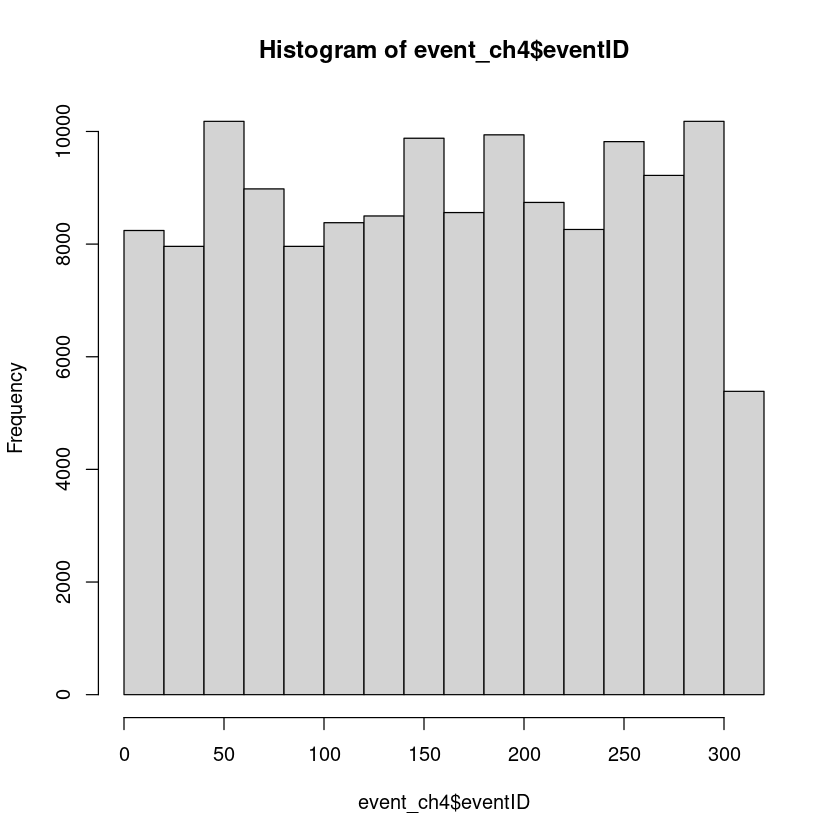

In [6]:
#create an event per entrance to the AMS per day per animal
event_ch4 <- rawCH4 %>%    
  select(ch4, co2, cow, date, datetime) %>%
  mutate(eventID = 1 + cumsum(cow != lag(cow, default = first(cow))))

hist(event_ch4$eventID)
head(event_ch4)

eventID,start_time,end_time,lenght
<dbl>,<dttm>,<dttm>,<dbl>
1,2022-02-18 00:00:01,2022-02-18 00:05:41,340
2,2022-02-18 00:05:43,2022-02-18 00:11:41,358
3,2022-02-18 00:11:43,2022-02-18 00:16:41,298
4,2022-02-18 00:16:43,2022-02-18 00:26:41,598
5,2022-02-18 00:26:43,2022-02-18 00:37:41,658
6,2022-02-18 00:37:43,2022-02-18 00:43:41,358


    eventID         start_time                    
 Min.   :  1.00   Min.   :2022-02-18 00:00:01.00  
 1st Qu.: 79.25   1st Qu.:2022-02-18 09:40:58.00  
 Median :157.50   Median :2022-02-18 18:57:43.00  
 Mean   :157.50   Mean   :2022-02-18 19:11:00.05  
 3rd Qu.:235.75   3rd Qu.:2022-02-19 04:48:58.00  
 Max.   :314.00   Max.   :2022-02-19 14:51:43.00  
    end_time                          lenght      
 Min.   :2022-02-18 00:05:41.00   Min.   : 238.0  
 1st Qu.:2022-02-18 09:46:11.00   1st Qu.: 358.0  
 Median :2022-02-18 19:02:41.00   Median : 418.0  
 Mean   :2022-02-18 19:18:25.51   Mean   : 445.5  
 3rd Qu.:2022-02-19 04:54:26.00   3rd Qu.: 478.0  
 Max.   :2022-02-19 15:01:41.00   Max.   :2098.0  

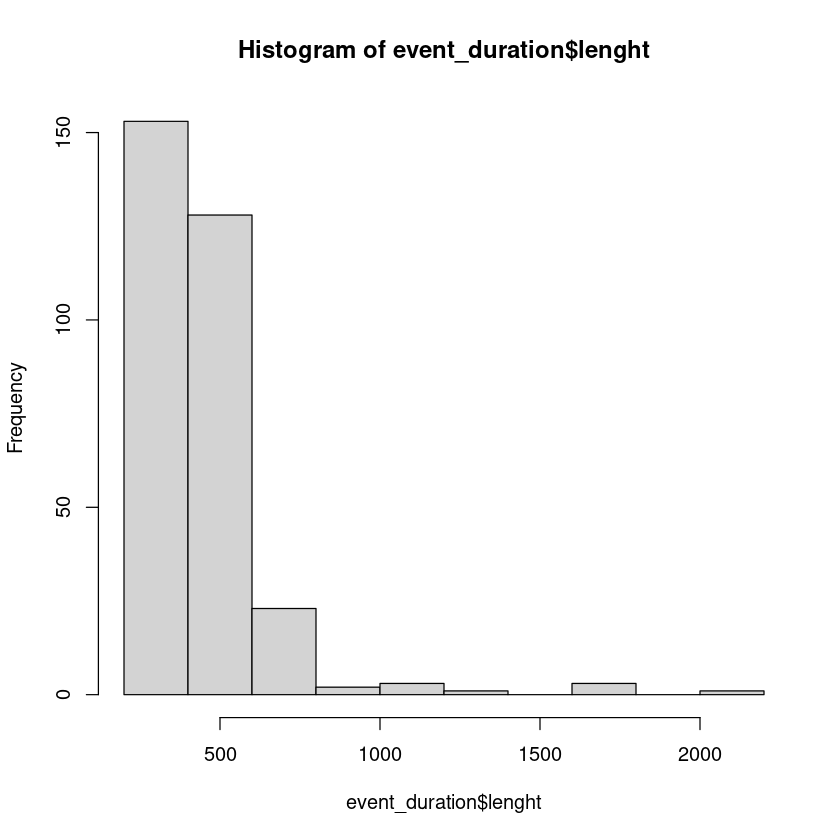

In [7]:
########## calculating duration of the visit ##############
event_duration <- event_ch4 %>%
  group_by(eventID) %>%
  summarize(
    start_time = min(datetime),
    end_time = max(datetime),
    lenght = as.numeric(difftime(max(datetime), min(datetime), units = "secs"))
  )
head(event_duration)
summary(event_duration)
hist(event_duration$lenght)

In [39]:
#Calculating how many events (visit) per cow 

event_counts <- event_ch4 %>%
  group_by(cow) %>%
  summarise(unique_events = n_distinct(eventID))

# View the result
print(event_counts)


# A tibble: 66 × 2
     cow unique_events
   <int>         <int>
 1    13             8
 2    21             3
 3    31             5
 4    32             3
 5    47             6
 6    49             3
 7    53             6
 8    58             3
 9    59             4
10    72             7
# ℹ 56 more rows


In [8]:
############ calculating the average of the lowest 3 or 5 measurements per visit to use it as background ########
event_5low <- event_ch4 %>%
  group_by(eventID) %>%
  arrange(ch4) %>%
  slice_head(n = 5) %>%
  summarise(avg_ch4 = mean(ch4, na.rm = TRUE))
head(event_5low)
summary(event_5low)

eventID,avg_ch4
<dbl>,<dbl>
1,0.0232
2,0.0252
3,0.0240
4,0.0180
5,0.0190
6,0.0260


    eventID          avg_ch4       
 Min.   :  1.00   Min.   :0.01100  
 1st Qu.: 79.25   1st Qu.:0.01700  
 Median :157.50   Median :0.02150  
 Mean   :157.50   Mean   :0.02197  
 3rd Qu.:235.75   3rd Qu.:0.02600  
 Max.   :314.00   Max.   :0.04640  

In [9]:
event_3low <- event_ch4 %>%
  group_by(eventID) %>%
  arrange(ch4) %>%
  slice_head(n = 3) %>%
  summarise(avg_ch4 = mean(ch4, na.rm = TRUE))
head(event_3low)
summary(event_3low)

eventID,avg_ch4
<dbl>,<dbl>
1,0.023
2,0.025
3,0.024
4,0.018
5,0.019
6,0.026


    eventID          avg_ch4       
 Min.   :  1.00   Min.   :0.01100  
 1st Qu.: 79.25   1st Qu.:0.01700  
 Median :157.50   Median :0.02117  
 Mean   :157.50   Mean   :0.02189  
 3rd Qu.:235.75   3rd Qu.:0.02600  
 Max.   :314.00   Max.   :0.04600  

In [10]:
############ calculating the 0.001 quantile per visit to use it as background ############
event_quant <- event_ch4 %>%
  group_by(eventID) %>%
  summarise(ch4_quantile_0_001 = quantile(ch4, probs = 0.001, na.rm = TRUE))
head(event_quant)
summary(event_quant)

eventID,ch4_quantile_0_001
<dbl>,<dbl>
1,0.023
2,0.025
3,0.024
4,0.018
5,0.019
6,0.026


    eventID       ch4_quantile_0_001
 Min.   :  1.00   Min.   :0.01100   
 1st Qu.: 79.25   1st Qu.:0.01700   
 Median :157.50   Median :0.02100   
 Mean   :157.50   Mean   :0.02186   
 3rd Qu.:235.75   3rd Qu.:0.02600   
 Max.   :314.00   Max.   :0.04600   

In [11]:
############### calculating the mean for ch4 and co2 per visit #################
event_means <- event_ch4 %>%
  group_by(eventID) %>%
  summarise(
    mean_ch4 = mean(ch4, na.rm = TRUE),
    mean_co2 = mean(co2, na.rm = TRUE)
  )
head(event_means)
summary(event_means)

eventID,mean_ch4,mean_co2
<dbl>,<dbl>,<dbl>
1,0.04187097,0.5155718
2,0.04133148,0.4482061
3,0.04255184,0.5642174
4,0.04149416,0.5497028
5,0.03828073,0.4690228
6,0.04255710,0.5621866


    eventID          mean_ch4          mean_co2      
 Min.   :  1.00   Min.   :0.01530   Min.   :0.08751  
 1st Qu.: 79.25   1st Qu.:0.02743   1st Qu.:0.30405  
 Median :157.50   Median :0.03608   Median :0.42164  
 Mean   :157.50   Mean   :0.03580   Mean   :0.39873  
 3rd Qu.:235.75   3rd Qu.:0.04288   3rd Qu.:0.50466  
 Max.   :314.00   Max.   :0.07181   Max.   :0.75020  

In [12]:
############# calculating the mean for ch4 only for 60-300 sec per visit ######## losing one event
event_cut <- event_ch4 %>%
  # Trim any spaces from the TimeStamp column
  mutate(datetime = trimws(datetime)) %>%
  # Convert TimeStamp to datetime object
  mutate(datetime = ymd_hms(datetime)) %>%
  group_by(eventID) %>%
  # Calculate the time difference in seconds from the first TimeStamp per eventID
  mutate(time_diff_sec = as.numeric(difftime(datetime, min(datetime), units = "secs"))) %>%
  # Filter to keep only rows where the time difference is between 60 and 300 seconds
  filter(time_diff_sec >= 60 & time_diff_sec <= 300) %>%
  # Optionally, summarize the data (for example, calculating means of ch4 and co2)
  summarise(
    mean_ch4 = mean(ch4, na.rm = TRUE),
    mean_co2 = mean(co2, na.rm = TRUE)
  )
head(event_cut)
summary(event_cut)
dim(event_cut)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `datetime = ymd_hms(datetime)`.
Caused by warning:
!  1 failed to parse.”


eventID,mean_ch4,mean_co2
<dbl>,<dbl>,<dbl>
1,0.04280083,0.5088548
2,0.04334025,0.4267427
3,0.04154393,0.5862678
4,0.04536100,0.6228091
5,0.04672199,0.5956722
6,0.04369710,0.5809004


    eventID         mean_ch4          mean_co2      
 Min.   :  1.0   Min.   :0.01169   Min.   :0.07066  
 1st Qu.: 79.0   1st Qu.:0.02664   1st Qu.:0.29787  
 Median :157.0   Median :0.03654   Median :0.42502  
 Mean   :157.4   Mean   :0.03617   Mean   :0.40357  
 3rd Qu.:236.0   3rd Qu.:0.04409   3rd Qu.:0.50909  
 Max.   :314.0   Max.   :0.07130   Max.   :0.80056  

[1] 313   3

In [13]:
#Printing cows numbers
cow_ids<- unique(event_ch4$cow)
print(cow_ids)


 [1]  59 236  31 231 532 240 259 208  13 197 138  47 132 141  90 228 245 134 473
[20] 185 150 146 212 233 226 227 246 195 412 117  84  81 220 224 160  21 175 153
[39] 130 168 170  77  72 291 221  53 163 516 280 394 198  76 171 149 196 167 404
[58]  32 218  49 302 247  58 249 206 392


In [14]:
#################### function to read the events of n cow ##################
# Function to get all events of a specific cow
get_unique_cow_event_ids <- function(cow_number) {
  cow_events <- subset(event_ch4, cow == cow_number)
  unique_event_ids <- unique(cow_events$eventID)
  return(unique_event_ids)
}

cow_number <- 72
unique_event_ids <- get_unique_cow_event_ids(cow_number)
print(unique_event_ids)


[1]  43  92 138 184 227 275 313


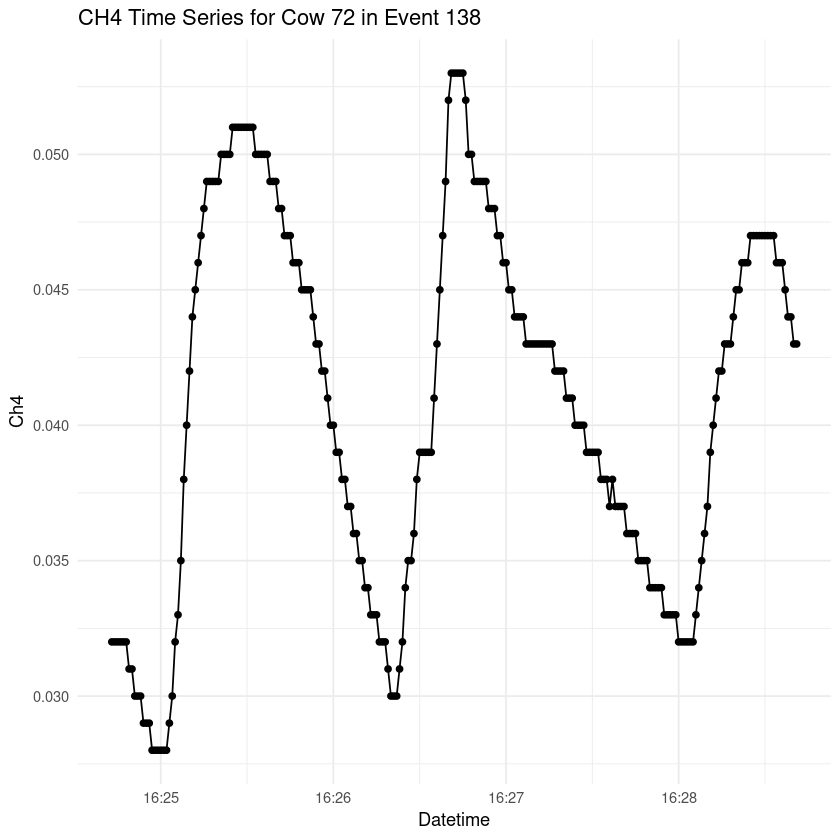

In [15]:
############# lets plot an event of a cow   ####### 

# Choose a specific cow and event for the plot
cow_id <- 72
event_id <- 138

plot_data <- subset(event_ch4, cow == cow_id & eventID == event_id)

# Create ggplot plot
p <- ggplot(plot_data, aes(x = datetime, y = ch4)) +
  geom_line() +
  geom_point() +
  labs(title = paste("CH4 Time Series for Cow", cow_id, "in Event", event_id),
       x = "Datetime",
       y = "Ch4") +
  theme_minimal()

# Explicitly print and assign a name to the plot
print(p)


In [16]:
# Function to detect peaks
detectPeaks <- function(ch4, windowSize = 5, threshold = 0.0005) {
  peaksIni <- c()
  peaksFin <- c()
  stage <- FALSE
  peak_decreasing <- FALSE
  
  for (i in 1:(length(ch4) - windowSize)) {
    tempW <- ch4[i:(i + windowSize - 1)]
    tempX <- 1:windowSize
    
    mean_tempW <- mean(tempW, na.rm = TRUE)
    mean_tempX <- mean(tempX, na.rm = TRUE)
    
    cov_xy <- sum((tempW - mean_tempW) * (tempX - mean_tempX), na.rm = TRUE)
    var_x <- sum((tempX - mean_tempX) * (tempX - mean_tempX), na.rm = TRUE)
    
    pendiente <- cov_xy / var_x
    
    if (pendiente > threshold && !stage) {
      peaksIni <- c(peaksIni, i)
      stage <- TRUE
      peak_decreasing <- FALSE
    } else if (stage && pendiente < -threshold) {
      peak_decreasing <- TRUE
    } else if (stage && peak_decreasing && pendiente > -threshold / 2) {
      peaksFin <- c(peaksFin, i)
      stage <- FALSE
      peak_decreasing <- FALSE
    } else if (length(peaksIni) == 0 && pendiente > threshold / 2) {
      # Handle case where no peaks have been detected yet
    } else if (i == (length(ch4) - windowSize) && peak_decreasing) {
      peaksFin <- c(peaksFin, i)
    }
  }
  
  list(peaksIni = peaksIni, peaksFin = peaksFin)
}

# Apply the peak detection to the entire database
peak_det <- event_ch4 %>%
  group_by(eventID) %>%
  summarise(num_peaks = length(detectPeaks(ch4)$peaksIni))

# Print the results
head(peak_det)
summary(peak_det)


eventID,num_peaks
<dbl>,<int>
1,4
2,5
3,5
4,8
5,5
6,4


    eventID         num_peaks     
 Min.   :  1.00   Min.   : 0.000  
 1st Qu.: 79.25   1st Qu.: 2.000  
 Median :157.50   Median : 4.000  
 Mean   :157.50   Mean   : 4.108  
 3rd Qu.:235.75   3rd Qu.: 6.000  
 Max.   :314.00   Max.   :13.000  

In [17]:
######################## EXERCISE #######################
#1)Calculate the num of peaks per  minute
    #HINT: Use merge, and lenght of event (visit) 

In [18]:
# Function to detect peaks and calculate sum2maxpeaks
detectPeaksAndSum <- function(ch4, windowSize = 5, threshold = 0.0005) {
  peaksIni <- c()
  peaksFin <- c()
  stage <- FALSE
  peak_decreasing <- FALSE
  
  for (i in 1:(length(ch4) - windowSize)) {
    tempW <- ch4[i:(i + windowSize - 1)]
    tempX <- 1:windowSize
    
    mean_tempW <- mean(tempW, na.rm = TRUE)
    mean_tempX <- mean(tempX, na.rm = TRUE)
    
    cov_xy <- sum((tempW - mean_tempW) * (tempX - mean_tempX), na.rm = TRUE)
    var_x <- sum((tempX - mean_tempX) * (tempX - mean_tempX), na.rm = TRUE)
    
    pendiente <- cov_xy / var_x
    
    if (pendiente > threshold && !stage) {
      peaksIni <- c(peaksIni, i)
      stage <- TRUE
      peak_decreasing <- FALSE
    } else if (stage && pendiente < -threshold) {
      peak_decreasing <- TRUE
    } else if (stage && peak_decreasing && pendiente > -threshold / 2) {
      peaksFin <- c(peaksFin, i)
      stage <- FALSE
      peak_decreasing <- FALSE
    } else if (length(peaksIni) == 0 && pendiente > threshold / 2) {
      # Handle case where no peaks have been detected yet
    } else if (i == (length(ch4) - windowSize) && peak_decreasing) {
      peaksFin <- c(peaksFin, i)
    }
  }
  
  sum2maxpeaks <- 0
  if (length(peaksIni) > 0 && length(peaksFin) > 0) {
    for (j in 1:length(peaksIni)) {
      start <- peaksIni[j]
      end <- ifelse(j <= length(peaksFin), peaksFin[j], NA)
      if (!is.na(end) && end > start) {
        peak_values <- ch4[start:end]
        max_values <- sort(peak_values, decreasing = TRUE)[1:2]
        avg_max_values <- mean(max_values)
        sum2maxpeaks <- sum2maxpeaks + avg_max_values
      }
    }
  }
  
  list(peaksIni = peaksIni, peaksFin = peaksFin, sum2maxpeaks = sum2maxpeaks)
}

# Apply the peak detection to the entire database
peak_phen <- event_ch4 %>%
  group_by(eventID) %>%
  summarise(
    num_peaks = {
      result <- detectPeaksAndSum(ch4)
      length(result$peaksIni)
    },
    sum2maxpeaks = {
      result <- detectPeaksAndSum(ch4)
      result$sum2maxpeaks
    }
  )

# Print the results
head(peak_phen)

eventID,num_peaks,sum2maxpeaks
<dbl>,<int>,<dbl>
1,4,0.2240
2,5,0.2120
3,5,0.2070
4,8,0.4220
5,5,0.2925
6,4,0.1680


In [19]:
# Function to detect peaks and calculate sum2maxpeaks and area under the curve
detectPeaksAndSum <- function(ch4, windowSize = 5, threshold = 0.0005) {
  peaksIni <- c()
  peaksFin <- c()
  stage <- FALSE
  peak_decreasing <- FALSE
  
  for (i in 1:(length(ch4) - windowSize)) {
    tempW <- ch4[i:(i + windowSize - 1)]
    tempX <- 1:windowSize
    
    mean_tempW <- mean(tempW, na.rm = TRUE)
    mean_tempX <- mean(tempX, na.rm = TRUE)
    
    cov_xy <- sum((tempW - mean_tempW) * (tempX - mean_tempX), na.rm = TRUE)
    var_x <- sum((tempX - mean_tempX) * (tempX - mean_tempX), na.rm = TRUE)
    
    pendiente <- cov_xy / var_x
    
    if (pendiente > threshold && !stage) {
      peaksIni <- c(peaksIni, i)
      stage <- TRUE
      peak_decreasing <- FALSE
    } else if (stage && pendiente < -threshold) {
      peak_decreasing <- TRUE
    } else if (stage && peak_decreasing && pendiente > -threshold / 2) {
      peaksFin <- c(peaksFin, i)
      stage <- FALSE
      peak_decreasing <- FALSE
    } else if (length(peaksIni) == 0 && pendiente > threshold / 2) {
      # Handle case where no peaks have been detected yet
    } else if (i == (length(ch4) - windowSize) && peak_decreasing) {
      peaksFin <- c(peaksFin, i)
    }
  }
  
  sum2maxpeaks <- 0
  area_under_curve <- 0
  if (length(peaksIni) > 0 && length(peaksFin) > 0) {
    for (j in 1:length(peaksIni)) {
      start <- peaksIni[j]
      end <- ifelse(j <= length(peaksFin), peaksFin[j], NA)
      if (!is.na(end) && end > start) {
        peak_values <- ch4[start:end]
        max_values <- sort(peak_values, decreasing = TRUE)[1:2]
        avg_max_values <- mean(max_values)
        sum2maxpeaks <- sum2maxpeaks + avg_max_values
        
        # Calculate area under the curve above ground level (assumed to be the minimum value in ch4)
        ground_level <- min(ch4)
        area_under_curve <- area_under_curve + sum(peak_values - ground_level)
      }
    }
  }
  
  list(peaksIni = peaksIni, peaksFin = peaksFin, sum2maxpeaks = sum2maxpeaks, area_under_curve = area_under_curve)
}

# Apply the peak detection to the entire database
AUC <- event_ch4 %>%
  group_by(eventID) %>%
  summarise(
    num_peaks = {
      result <- detectPeaksAndSum(ch4)
      length(result$peaksIni)
    },
    sum2maxpeaks = {
      result <- detectPeaksAndSum(ch4)
      result$sum2maxpeaks
    },
    area_under_curve = {
      result <- detectPeaksAndSum(ch4)
      result$area_under_curve
    }
  )

# Print the results
head(AUC)

eventID,num_peaks,sum2maxpeaks,area_under_curve
<dbl>,<int>,<dbl>,<dbl>
1,4,0.2240,4.723
2,5,0.2120,5.059
3,5,0.2070,3.295
4,8,0.4220,12.961
5,5,0.2925,11.385
6,4,0.1680,3.974


In [20]:
############################### now for the 'cut' visit ###########################

# Calculate the time difference in seconds from the first TimeStamp per eventID
event_ch42<- event_ch4 %>%
  group_by(eventID) %>%
  mutate(time_diff_sec = as.numeric(difftime(datetime, min(datetime), units = "secs"))) %>%
  ungroup()

# Function to detect peaks and calculate sum2maxpeaks and area under the curve
detectPeaksAndSum <- function(ch4, windowSize = 5, threshold = 0.0005) {
  peaksIni <- c()
  peaksFin <- c()
  stage <- FALSE
  peak_decreasing <- FALSE
  
  for (i in 1:(length(ch4) - windowSize)) {
    tempW <- ch4[i:(i + windowSize - 1)]
    tempX <- 1:windowSize
    
    mean_tempW <- mean(tempW, na.rm = TRUE)
    mean_tempX <- mean(tempX, na.rm = TRUE)
    
    cov_xy <- sum((tempW - mean_tempW) * (tempX - mean_tempX), na.rm = TRUE)
    var_x <- sum((tempX - mean_tempX) * (tempX - mean_tempX), na.rm = TRUE)
    
    pendiente <- cov_xy / var_x
    
    if (pendiente > threshold && !stage) {
      peaksIni <- c(peaksIni, i)
      stage <- TRUE
      peak_decreasing <- FALSE
    } else if (stage && pendiente < -threshold) {
      peak_decreasing <- TRUE
    } else if (stage && peak_decreasing && pendiente > -threshold / 2) {
      peaksFin <- c(peaksFin, i)
      stage <- FALSE
      peak_decreasing <- FALSE
    } else if (length(peaksIni) == 0 && pendiente > threshold / 2) {
      # Handle case where no peaks have been detected yet
    } else if (i == (length(ch4) - windowSize) && peak_decreasing) {
      peaksFin <- c(peaksFin, i)
    }
  }
  
  sum2maxpeaks <- 0
  area_under_curve <- 0
  if (length(peaksIni) > 0 && length(peaksFin) > 0) {
    for (j in 1:length(peaksIni)) {
      start <- peaksIni[j]
      end <- ifelse(j <= length(peaksFin), peaksFin[j], NA)
      if (!is.na(end) && end > start) {
        peak_values <- ch4[start:end]
        max_values <- sort(peak_values, decreasing = TRUE)[1:2]
        avg_max_values <- mean(max_values)
        sum2maxpeaks <- sum2maxpeaks + avg_max_values
        
        # Calculate area under the curve above ground level (assumed to be the minimum value in ch4)
        ground_level <- min(ch4)
        area_under_curve <- area_under_curve + sum(peak_values - ground_level)
      }
    }
  }
  
  list(peaksIni = peaksIni, peaksFin = peaksFin, sum2maxpeaks = sum2maxpeaks, area_under_curve = area_under_curve)
}

# Apply the peak detection to the entire database, considering only data between 60 sec to 300 sec per eventID
peak_phen2 <- event_ch42 %>%
  filter(time_diff_sec >= 60 & time_diff_sec <= 300) %>%
  group_by(eventID) %>%
  summarise(
    num_peaks = {
      result <- detectPeaksAndSum(ch4)
      length(result$peaksIni)
    },
    sum2maxpeaks = {
      result <- detectPeaksAndSum(ch4)
      result$sum2maxpeaks
    },
    area_under_curve = {
      result <- detectPeaksAndSum(ch4)
      result$area_under_curve
    }
  )

# Print the results
head(peak_phen2)
dim(peak_phen2)

eventID,num_peaks,sum2maxpeaks,area_under_curve
<dbl>,<int>,<dbl>,<dbl>
1,3,0.088,0.994
2,4,0.146,2.317
3,5,0.207,3.295
4,4,0.160,1.830
5,3,0.110,3.092
6,3,0.114,2.690


[1] 314   4

In [21]:
#Adding moving average, play with the window sizes
detectPeaksAndSum <- function(ch4, windowSize = 5, threshold = 0.0005) {
  peaksIni <- c()
  peaksFin <- c()
  stage <- FALSE
  peak_decreasing <- FALSE
  
  for (i in 1:(length(ch4) - windowSize)) {
    tempW <- ch4[i:(i + windowSize - 1)]
    tempX <- 1:windowSize
    
    mean_tempW <- mean(tempW, na.rm = TRUE)
    mean_tempX <- mean(tempX, na.rm = TRUE)
    
    cov_xy <- sum((tempW - mean_tempW) * (tempX - mean_tempX), na.rm = TRUE)
    var_x <- sum((tempX - mean_tempX) * (tempX - mean_tempX), na.rm = TRUE)
    
    pendiente <- cov_xy / var_x
    
    if (pendiente > threshold && !stage) {
      peaksIni <- c(peaksIni, i)
      stage <- TRUE
      peak_decreasing <- FALSE
    } else if (stage && pendiente < -threshold) {
      peak_decreasing <- TRUE
    } else if (stage && peak_decreasing && pendiente > -threshold / 2) {
      peaksFin <- c(peaksFin, i)
      stage <- FALSE
      peak_decreasing <- FALSE
    } else if (length(peaksIni) == 0 && pendiente > threshold / 2) {
      # Handle case where no peaks have been detected yet
    } else if (i == (length(ch4) - windowSize) && peak_decreasing) {
      peaksFin <- c(peaksFin, i)
    }
  }
  
  sum2maxpeaks <- 0
  area_under_curve <- 0
  if (length(peaksIni) > 0 && length(peaksFin) > 0) {
    for (j in 1:length(peaksIni)) {
      start <- peaksIni[j]
      end <- ifelse(j <= length(peaksFin), peaksFin[j], NA)
      if (!is.na(end) && end > start) {
        peak_values <- ch4[start:end]
        max_values <- sort(peak_values, decreasing = TRUE)[1:2]
        avg_max_values <- mean(max_values)
        sum2maxpeaks <- sum2maxpeaks + avg_max_values
        
        # Calculate area under the curve above ground level (assumed to be the minimum value in ch4)
        ground_level <- min(ch4)
        area_under_curve <- area_under_curve + sum(peak_values - ground_level)
      }
    }
  }
  
  list(peaksIni = peaksIni, peaksFin = peaksFin, sum2maxpeaks = sum2maxpeaks, area_under_curve = area_under_curve)
}

# Function to calculate the average of the moving average of CH4 values
calculate_moving_avg <- function(ch4, window_size) {
  moving_avg <- rollmean(ch4, k = window_size, fill = NA)
  mean(moving_avg, na.rm = TRUE)
}

# Apply the peak detection to the entire database, considering only data between 60 sec to 300 sec per eventID
all_phen <- event_ch42 %>%
  filter(time_diff_sec >= 60 & time_diff_sec <= 300) %>%
  group_by(eventID) %>%
  summarise(
    num_peaks = {
      result <- detectPeaksAndSum(ch4)
      length(result$peaksIni)
    },
    sum2maxpeaks = {
      result <- detectPeaksAndSum(ch4)
      result$sum2maxpeaks
    },
    area_under_curve = {
      result <- detectPeaksAndSum(ch4)
      result$area_under_curve
    },
    avg_moving_avg_ch4 = calculate_moving_avg(ch4, window_size = 10) # Change window_size as needed
  )

# Print the results
head(all_phen)
dim(all_phen)

eventID,num_peaks,sum2maxpeaks,area_under_curve,avg_moving_avg_ch4
<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,3,0.088,0.994,0.04282543
2,4,0.146,2.317,0.04315560
3,5,0.207,3.295,0.04170783
4,4,0.160,1.830,0.04552284
5,3,0.110,3.092,0.04667543
6,3,0.114,2.690,0.04372500


[1] 314   5

In [35]:
#calculate all the phenotypes with cut and not cut and calculate correlations among the phenotypes
#HINT1: use merge or join
merged<- merge(event_5low, event_quant, by="eventID")
head(merged)
merged2<- left_join(event_5low, event_3low, by="eventID")
head(merged2)
#HINT2: use cor and choose the method kendall, spearman or pearson
cor(event_5low$avg_ch4, event_3low$avg_ch4, method="kendall", use="complete.obs")
cor(event_means$mean_ch4, event_means$mean_co2, method="pearson", use="complete.obs")

,eventID,avg_ch4,ch4_quantile_0_001
,<dbl>,<dbl>,<dbl>
1,1,0.0232,0.023
2,2,0.0252,0.025
3,3,0.0240,0.024
4,4,0.0180,0.018
5,5,0.0190,0.019
6,6,0.0260,0.026


eventID,avg_ch4.x,avg_ch4.y
<dbl>,<dbl>,<dbl>
1,0.0232,0.023
2,0.0252,0.025
3,0.0240,0.024
4,0.0180,0.018
5,0.0190,0.019
6,0.0260,0.026


[1] 0.9934228

[1] 0.8999663